In [1]:
#this is dogify
import zipfile
import pandas as pd
import torchvision
import torch
from torchvision import transforms,models
import os,time
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,ConcatDataset,DataLoader,random_split
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from PIL import Image as PilImage
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imageio
from tqdm.notebook import tqdm as tqdm
import shutil 
import shap
from IPython.display import Image
from torchsummary import summary
import torch.optim as optim
from torch.optim import lr_scheduler

import warnings
warnings.filterwarnings('ignore')

c:\Users\ACER NITRO\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\ACER NITRO\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
#unzip the folder
#with zipfile.ZipFile('C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/dog-breed-identification (1).zip','r') as zip:
#    zip.extractall('C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/')

In [3]:
label_csv = pd.read_csv('labels.csv')
label_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

In [4]:
#we have 10222 images
label_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [5]:
label_csv.head(5)

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [6]:
label_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

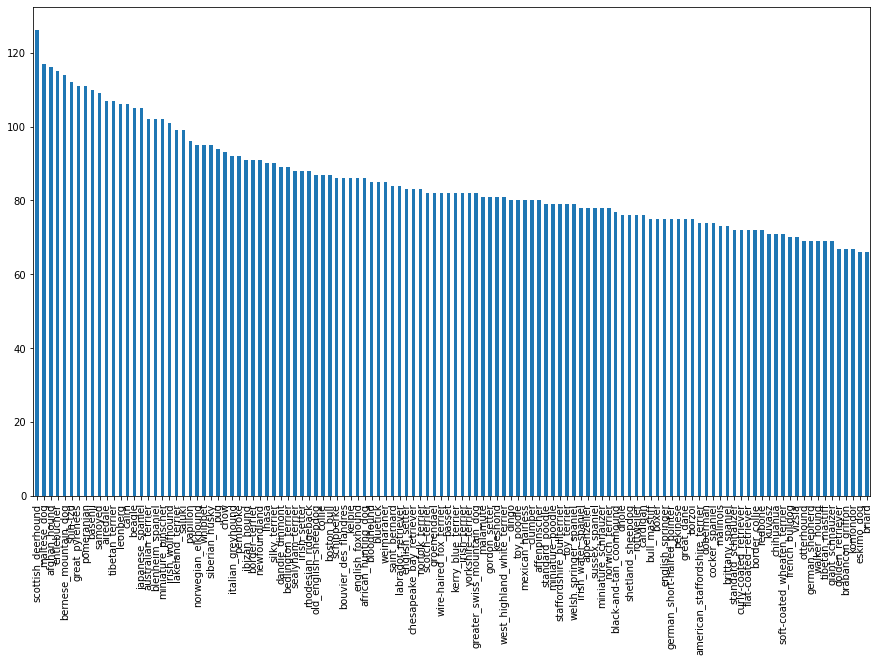

In [7]:
#plot label class(it shows that there is not massive imbalance in the dataset)
label_csv['breed'].value_counts().plot(kind= 'bar',figsize = (15,9));

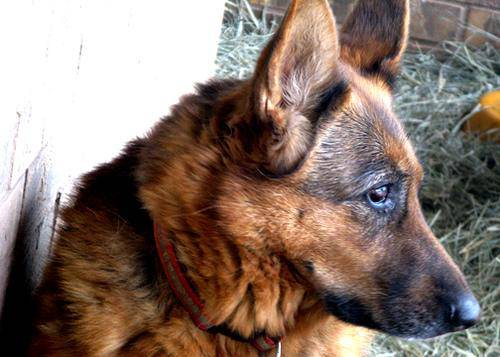

In [8]:
#display an image
Image('test/0a51fbac72fac75df279e18e4b1c042f.jpg')

In [9]:
#create a list of images filepath,the id column in labels.csv is the name of the file
filenames = np.array(['train/' + i for i in os.listdir('train')])
filenames[:10]

array(['train/000bec180eb18c7604dcecc8fe0dba07.jpg',
       'train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
       'train/001cdf01b096e06d78e9e5112d419397.jpg',
       'train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
       'train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
       'train/002211c81b498ef88e1b40b9abf84e1d.jpg',
       'train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
       'train/002a283a315af96eaea0e28e7163b21b.jpg',
       'train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
       'train/0042188c895a2f14ef64a918ed9c7b64.jpg'], dtype='<U42')

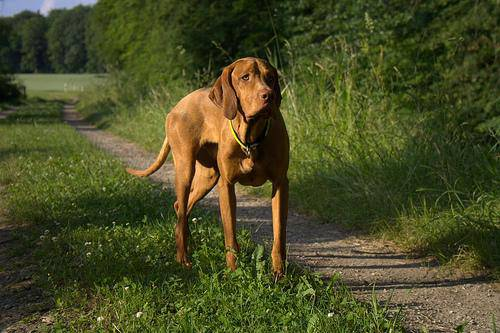

In [10]:
#view a random dog image,that's adorable❤
Image(filenames[np.random.randint(1,len(label_csv) / 2)])

In [11]:
#check that image lenghts is the same for train file and filenames
print('same length' if len(os.listdir('train')) == len(filenames) else 'different lenght')

same length


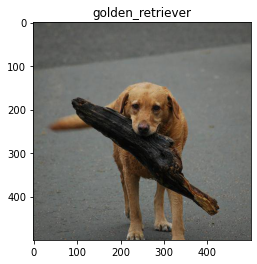

In [12]:
#yep,that is a golden retrieval
plt.imshow(imageio.imread(filenames[4]))
plt.title(label_csv.iloc[4]['breed'])
plt.show()

In [13]:
#fish out breed as our label
labels = np.array(label_csv['breed'])
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
#print out the unique breeds
unique_labels = np.unique(labels)
print(unique_labels)

['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'
 'irish_terrier' 'irish_water_spaniel' 'irish_wolfhound'
 'italian

In [15]:
#turn labels into boolean array
bool_label = [label == unique_labels for label in labels]
print(bool_label[1]) #second label
print(bool_label[1].argmax())
print(labels[1])
print(unique_labels[bool_label[1].argmax()])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
37
dingo
dingo


In [16]:
labels.shape

(10222,)

In [17]:
#i need code this later to identify the name for model output
unique_labels[bool_label[1].argmax()]

'dingo'

In [18]:
class Dataset():
    def __init__(self,filelist,filepath,transforms = None) -> None:
        self.filelist = filelist
        self.filepath = filepath
        self.transforms = transforms
    def __len__(self):
        return int(len(self.filelist))
    def __getitem__(self,index):
        imgpath = os.path.join(self.filepath,self.filelist[index])
        img = PilImage.open(imgpath)
        if self.transforms is not None:
            img = self.transforms(img)
        label = int(bool_label[index].argmax())
        return (img,label)
        

In [19]:
#create a function to build the dataloaders
batch_size = 32
def create_data_loaders(batch_size = batch_size,image_size = 60,test_data = False):
    if test_data:
        print('creating test data loader')
        transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((image_size,image_size))
        ])
        test_dir = './test'
        test_files = os.listdir(test_dir)
        tester = Dataset(test_files,test_dir,transforms=transformations)
        test_loader = DataLoader(dataset = tester,batch_size = batch_size,shuffle = False)
        return test_loader
    else:
        print('creating train and val data loaders')
        transformations = transforms.Compose([
        #transforms.RandomAffine(degrees = 10, translate = (0.05,0.05), shear = 5), 
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(hue = .05, saturation = .05),
        #transforms.RandomGrayscale(p=1),
        transforms.ToTensor(),
        transforms.Resize((image_size,image_size)),
        transforms.Normalize((0.5, ), (0.5, ))
        ])
        train_dir = './train'
        train_files = os.listdir(train_dir)
        train = Dataset(train_files,train_dir,transforms=transformations)
        proportions = [.80, .25]
        lengths = [int(p * len(train)) for p in proportions]
        lengths[-1] = len(train) - sum(lengths[:-1])
        print(lengths)    
        train,val = random_split(train,lengths)
        train_loader = DataLoader(train,batch_size = batch_size,shuffle = True)
        val_loader = DataLoader(val,batch_size = batch_size,shuffle = False)
        return (train_loader,train),(val_loader,val)


In [20]:
(train_loader,train),(val_loader,val) = create_data_loaders()
test_loader = create_data_loaders(test_data=True)

creating train and val data loaders
[8177, 2045]
creating test data loader


In [21]:
print(len(os.listdir('./train')))

10222


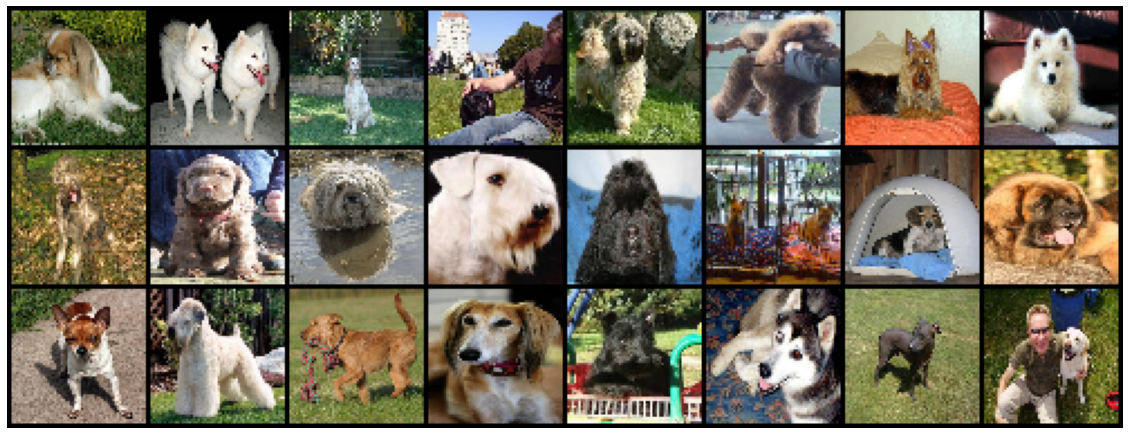

In [22]:
#show some images for train and test loaders
samples, labels = iter(test_loader).next()
plt.figure(figsize=(20,28))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


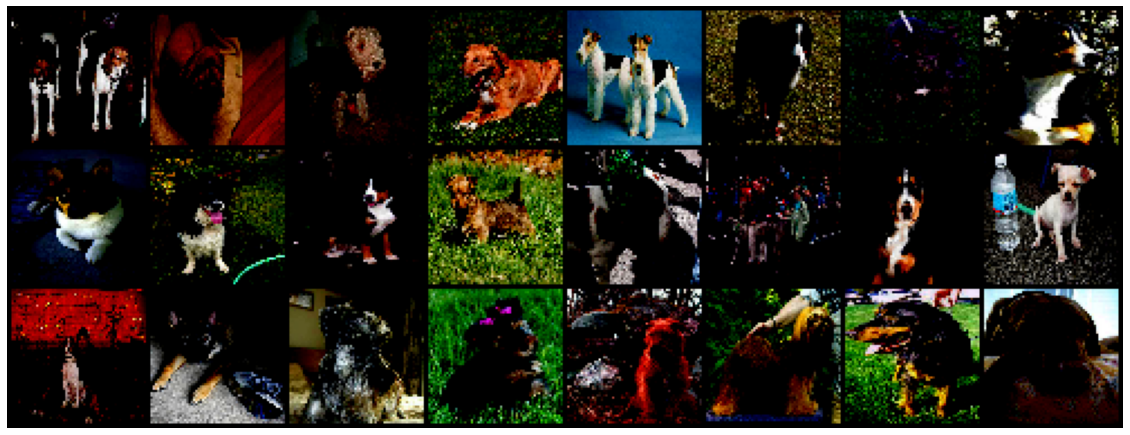

In [23]:
#show some images
samples, labels = iter(train_loader).next()
plt.figure(figsize=(20,28))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.axis('off')
plt.show()

In [200]:
#model architecture using pytorch lightning
num_classes = len(unique_labels)
class LitModel(pl.LightningModule):
    def __init__(self,learning_rate,batch_size) -> None:
        super().__init__()
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.accuracy = torchmetrics.Accuracy(task="multiclass",num_classes=num_classes)
        self.train_acc = torchmetrics.Accuracy(task="multiclass",num_classes=num_classes)
        self.valid_acc = torchmetrics.Accuracy(task="multiclass",num_classes=num_classes)
        self.conv1 = nn.Sequential(nn.Conv2d(3,16,3),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(16,32,3),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(32,64,3),nn.ReLU(),nn.MaxPool2d(2,2))
        self.fc1 = nn.Sequential(nn.Flatten(),nn.Linear(64 * 5 * 5,1026),nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(1026,514),nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(514,128),nn.ReLU())
        self.fc4 = nn.Sequential(nn.Linear(128,num_classes),)
    def train_dataloader(self):
        return train_loader
    def val_dataloader(self):
        return val_loader
    def cross_entropy_loss(self,logits,labels):
        return F.nll_loss(logits,labels)
    def training_step(self,batch,batch_idx):
        data,label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output,label)
        self.log('train_loss',loss)
        self.log('train_acc_step',self.accuracy(output,label))
        return dict(loss = loss,log = self.log)
    def training_epoch_end(self,outs):
        self.log('train_acc_epoch',self.accuracy.compute())
    def validation_step(self,batch,batch_idx):
        val_data,val_label = batch
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output,val_label)
        self.log('val_acc_step',self.accuracy(val_output,val_label))
        self.log('val_loss',val_loss)
    def validation_epoch_end(self,outs):
        self.log('val_acc_epoch',self.accuracy.compute())
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=(self.learning_rate))
        return optimizer
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return F.log_softmax(x,dim = 1)

In [24]:
import torchvision.models as models
num_classes = len(unique_labels)
class ImagenetTransferLearning(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.accuracy = torchmetrics.Accuracy(task="multiclass",num_classes=num_classes)

        # init a pretrained resnet
        backbone = models.resnet50(pretrained=True)
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        # use the pretrained model
        self.classifier = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        # Change our forward function to include the 4 lines below
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return F.softmax(x,dim = 1) 

    def train_dataloader(self):
        return torch.utils.data.DataLoader(train,batch_size=32,shuffle=True,num_workers=0)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(val,batch_size=32,shuffle=True,num_workers=0)

    def cross_entropy_loss(self, logits, labels):
        return F.nll_loss(logits, labels)

    def training_step(self, batch, batch_idx):
        data, label = batch
        output = self.forward(data)
        loss = nn.CrossEntropyLoss()(output,label)
        self.log('train_loss', loss)
        self.log('train_acc_step', self.accuracy(output, label))
        return {'loss': loss, 'log': self.log}

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log('train_acc_epoch', self.accuracy.compute())

    def validation_step(self, batch, batch_idx):
        val_data, val_label = batch
        val_data = val_data.float()
        val_output = self.forward(val_data)
        val_loss = nn.CrossEntropyLoss()(val_output, val_label)
        self.log('val_acc_step', self.accuracy(val_output, val_label))
        self.log('val_loss', val_loss)

    def validation_epoch_end(self, outs):
        # log epoch metric
        self.log('val_acc_epoch', self.accuracy.compute())

    def configure_optimizers(self):
        #optimizer = torch.optim.Adam(self.parameters(), lr=(self.learning_rate))
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [25]:
#create earlystopping function and checkpointing
earlystopping = EarlyStopping(
    monitor = 'val_loss',
    patience=3,
    strict = False,
    verbose= True,
    mode = 'min'
)
checkpoint_callback = ModelCheckpoint(
    monitor = 'val_loss',
    dirpath = 'models/',
    filename = 'sample-dogify-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode= 'min'
)
class MyPrintingCallback(pl.callbacks.Callback):
    def on_train_start(self,trainer,pl_module):
        print('Training Started...')
    def on_train_end(self,trainer,pl_module):
        print('Training Done...')

In [26]:
model = ImagenetTransferLearning()
trainer = pl.Trainer(
    gpus = 1,
    max_epochs = 15,
    callbacks = [
    earlystopping,
    checkpoint_callback,
    MyPrintingCallback()
])
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type               | Params
---------------------------------------------------------
0 | accuracy          | MulticlassAccuracy | 0     
1 | feature_extractor | Sequential         | 23.5 M
2 | classifier        | Linear             | 245 K 
---------------------------------------------------------
23.8 M    Trainable params
0         Non-trainable params
23.8 M    Total params
95.016    Total estimated model params size (MB)


Training Started...                                                        
Epoch 0: 100%|██████████| 10222/10222 [09:39<00:00, 17.63it/s, loss=4.8, v_num=5]

Metric val_loss improved. New best score: 4.793


Epoch 1:  78%|███████▊  | 7957/10222 [08:10<02:19, 16.21it/s, loss=4.8, v_num=5] 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [29]:
#get the best model
pretrained_model = LitModel.load_from_checkpoint(batch_size = 32,learning_rate = 1e-2,checkpoint_path=checkpoint_callback.best_model_path)
pretrained_model = pretrained_model.to('cuda')
pretrained_model.eval()
pretrained_model.freeze()

In [ ]:
#run inference on 32 images
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
samples,actual_label = iter(test_loader).next()
samples = samples.to(device)
fig = plt.figure(figsize = (20,14))
fig.tight_layout()
output = model_btchnrm(samples[:40])
pred = torch.argmax(output,dim =1)
pred = [p.item() for p in pred]
print(pred)
print(unique_labels[bool_label[97].argmax()])
for num,sample in enumerate(samples[:24]):
    plt.subplot(4,6,num+1)
    '''if ad[pred[num]] == ad[actual_label.numpy()[:][num]]:
        color = 'green'
    else:
        color = 'red'
        '''
    plt.title(unique_labels[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample,(1,2,0)))
plt.show()    

In [17]:
#trying something else
class Build_data():
    def __init__(self,data_path) -> None:
        self.img_size = 256
        self.training_data = []
        self.data_path = data_path
    def build_trainng_data(self,imgarr_path,rebuild = True,test = False):
        if rebuild:
            for ind,imgpth in tqdm(enumerate(os.listdir(self.data_path))):
                try:
                    path = os.path.join(self.data_path,imgpth)
                    image = cv2.imread(path)
                    #print(image)
                    image = cv2.resize(image,(self.img_size,self.img_size))
                    image = np.array(image)
                    if test:
                        self.training_data.append(image)
                        if ind > 2000:
                            break
                    else:
                        self.training_data.append([image,int(bool_label[ind].argmax())])
                    #print(self.training_data)                
                except Exception as e:
                    print(e)
                    pass
            #shuffle around the training data numpy file
            np.random.shuffle(self.training_data)
            img_path = f'C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/{imgarr_path}.npy'
            np.save(img_path,self.training_data)
            return img_path
        else:
            print('set rebuild argument to True to rebuild the dataset')
            pass

In [18]:
[np.array(cv2.resize(cv2.imread('test/' + i),(256,256))) for i in os.listdir('test')[:5]][4] / 255

array([[[0.08235294, 0.15686275, 0.09019608],
        [0.09019608, 0.16470588, 0.09803922],
        [0.10196078, 0.17647059, 0.10980392],
        ...,
        [0.11764706, 0.2       , 0.15294118],
        [0.11372549, 0.16470588, 0.1254902 ],
        [0.10980392, 0.14509804, 0.10588235]],

       [[0.0745098 , 0.14901961, 0.08235294],
        [0.08235294, 0.15686275, 0.09019608],
        [0.09411765, 0.16862745, 0.10588235],
        ...,
        [0.15294118, 0.23529412, 0.18823529],
        [0.1372549 , 0.19215686, 0.14901961],
        [0.12156863, 0.16470588, 0.12156863]],

       [[0.05882353, 0.13333333, 0.06666667],
        [0.0745098 , 0.14901961, 0.08235294],
        [0.09019608, 0.16470588, 0.09803922],
        ...,
        [0.19215686, 0.2745098 , 0.23529412],
        [0.15294118, 0.21568627, 0.18039216],
        [0.12156863, 0.16862745, 0.1372549 ]],

       ...,

       [[0.04705882, 0.15686275, 0.08627451],
        [0.09019608, 0.2       , 0.12941176],
        [0.12941176, 0

In [19]:
#instantiate the build_data class to create a numpy file of the images file
data = Build_data(data_path='C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/train')
img_arr_path = 'images256train'
img_path = data.build_trainng_data(img_arr_path,rebuild=True)
dataset = np.load(img_path,allow_pickle=True)
print('Done...')

0it [00:00, ?it/s]

Done...


In [20]:
[(i,bool_label[i].argmax(),unique_labels[bool_label[i].argmax()]) for i,v  in enumerate(zip(os.listdir('C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/train')))][:10]

[(0, 19, 'boston_bull'),
 (1, 37, 'dingo'),
 (2, 85, 'pekinese'),
 (3, 15, 'bluetick'),
 (4, 49, 'golden_retriever'),
 (5, 10, 'bedlington_terrier'),
 (6, 10, 'bedlington_terrier'),
 (7, 18, 'borzoi'),
 (8, 7, 'basenji'),
 (9, 97, 'scottish_deerhound')]

In [21]:
print(len(dataset))

10222


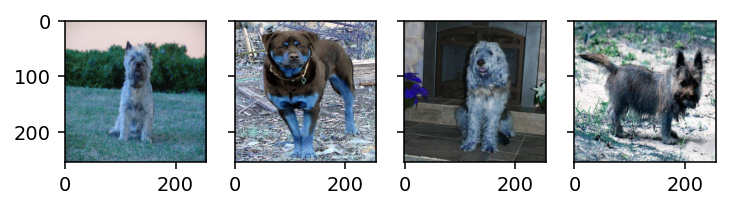

In [22]:
fig,axes = plt.subplots(1,4,dpi = 140,sharey=True)
for ax in axes.ravel():
    ax.imshow(dataset[np.random.randint(len(dataset))][0])

In [23]:
#trying to split the dataset
def train_Val_split(dataset,val_pct):
    number_of_instances = len(dataset)
    val_idx = int(number_of_instances * val_pct)
    idx = list(np.random.permutation(number_of_instances))
    return idx[:val_idx],idx[val_idx:]

In [24]:
val_ind,train_ind = train_Val_split(dataset=dataset,val_pct=0.3)

#save the valdation and 
np.save(f'C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/numpyfile/numpytrainfile.npy',train_ind)
np.save(f'C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/numpyfile/numpyvalfile.npy',val_ind)

#load dataset
train_ind = list(np.load(f'C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/numpyfile/numpytrainfile.npy',allow_pickle=True))
val_ind = list(np.load(f'C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/numpyfile/numpyvalfile.npy',allow_pickle=True))

train_set = dataset[train_ind]
val_set = dataset[val_ind]

In [31]:
class imagesDataset(Dataset):
    def __init__(self,loaded_dataset,transforms = None,test = False):
        self.loaded_dataset = loaded_dataset
        self.transforms = transforms
        self.test = test
    def __len__(self):
        return int(len(self.loaded_dataset))
    def __getitem__(self,index):
        if self.test:
            image = self.loaded_dataset[index] / 255
            if self.transforms is not None:
                image = self.transforms(image)
            return image
        else:
            image = self.loaded_dataset[index][0] / 255
            #image = image.astype(np.float32)
            #image = transforms.functional.to_pil_image(image)
            label = torch.tensor(int(self.loaded_dataset[index][1]))
            if self.transforms is not None:
                image = self.transforms(image)
            return (image,label)

In [32]:
#prepare test data
def create_test_loader():
    print('Creating test loader...')
    data = Build_data(data_path='C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/test')
    img_arr_path = 'images256test'
    img_path = data.build_trainng_data(img_arr_path,rebuild=True,test=True)
    dataset = np.load(img_path,allow_pickle=True)
    transformation_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((100,100))
    ])
    test_dataset = imagesDataset(dataset,transforms=transformation_test,test=True)
    print('done creating dataset')
    print('test dataset lenght-->',len(dataset))
    print('test dataset shape',test_dataset.__getitem__(0).shape)
    test_loader = DataLoader(test_dataset,batch_size=batch_size)
    print('Done...')
    return test_loader

In [33]:
#create the dataset transformations
transformation_tr = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    #transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),    
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    #transforms.RandomCrop(32, padding=4),
    transforms.Resize((100,100)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transformation_vl = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((100,100)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [34]:
#create instance for train and val dataset
train_dataset = imagesDataset(train_set,transforms=transformation_tr)
val_dataset = imagesDataset(val_set,transforms=transformation_vl)

#build dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset,batch_size=batch_size)
val_loader = DataLoader(val_dataset,batch_size=batch_size)

In [35]:
print(train_dataset.__getitem__(0)[0].shape)
print(val_dataset.__getitem__(0)[0].shape)

torch.Size([3, 100, 100])
torch.Size([3, 100, 100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


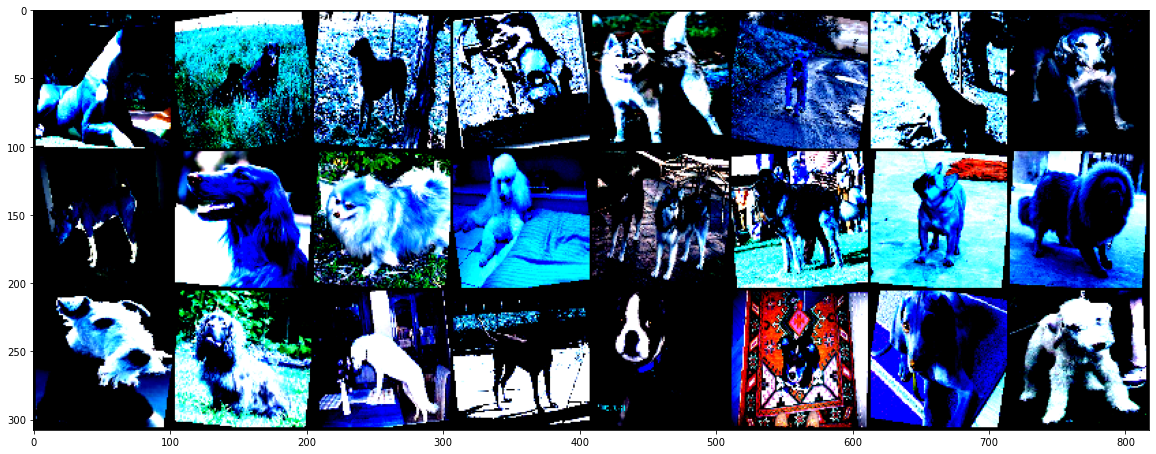

In [36]:
#show some images
samples, labels = iter(train_loader).next()
plt.figure(figsize=(20,28))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.show()

In [ ]:
rgb_img = np.squeeze(samples[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            x_y = img[x][y]
            val = np.round(x_y,2) if x_y !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [39]:
#normal pytorch network
num_classes = len(unique_labels)
class Net_btchnrm(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,32,3),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,32,3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64,128,3),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(128,128,3),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(128,128,3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8192,514),
            nn.BatchNorm1d(514),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2_1 = nn.Sequential(
            nn.Linear(514,514),
            nn.BatchNorm1d(514),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(514,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(128,num_classes)
        )
    def forward(self,x):
        x = x.view(-1,3,100,100).float()
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.fc2_1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x,dim = 1)
    

In [40]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [41]:
model_btchnrm = Net_btchnrm()
model_btchnrm.to(device)
summary(model_btchnrm,(3,100,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 98, 98]             896
       BatchNorm2d-2           [-1, 32, 98, 98]              64
              ReLU-3           [-1, 32, 98, 98]               0
            Conv2d-4           [-1, 32, 96, 96]           9,248
       BatchNorm2d-5           [-1, 32, 96, 96]              64
              ReLU-6           [-1, 32, 96, 96]               0
         MaxPool2d-7           [-1, 32, 48, 48]               0
            Conv2d-8           [-1, 64, 46, 46]          18,496
       BatchNorm2d-9           [-1, 64, 46, 46]             128
             ReLU-10           [-1, 64, 46, 46]               0
           Conv2d-11           [-1, 64, 44, 44]          36,928
      BatchNorm2d-12           [-1, 64, 44, 44]             128
             ReLU-13           [-1, 64, 44, 44]               0
        MaxPool2d-14           [-1, 64,

In [47]:
class NetBL(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,32,3),
            nn.ReLU()
            )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(64,128,3),
            nn.ReLU(),
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(128,128,3),
            nn.ReLU(),
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(128,128,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8192,514),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(514,128),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(128,num_classes)
        # Use He initialization for the linear layers
        #nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        #nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
    def forward(self,x):
        x = x.view(-1,3,100,100).float()
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x,dim = 1)


In [48]:
model_bl = NetBL()
model_bl = model_bl.to(device)

In [49]:
summary(model_bl,(3,100,100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 98, 98]             896
              ReLU-2           [-1, 32, 98, 98]               0
            Conv2d-3           [-1, 32, 96, 96]           9,248
              ReLU-4           [-1, 32, 96, 96]               0
         MaxPool2d-5           [-1, 32, 48, 48]               0
            Conv2d-6           [-1, 64, 46, 46]          18,496
              ReLU-7           [-1, 64, 46, 46]               0
            Conv2d-8           [-1, 64, 44, 44]          36,928
              ReLU-9           [-1, 64, 44, 44]               0
        MaxPool2d-10           [-1, 64, 22, 22]               0
           Conv2d-11          [-1, 128, 20, 20]          73,856
             ReLU-12          [-1, 128, 20, 20]               0
           Conv2d-13          [-1, 128, 18, 18]         147,584
             ReLU-14          [-1, 128,

In [50]:
#train
def train_val_function(network,epochs,optimizer,criterion,train_loader,val_loader):
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    metrics_log = []

    for epoch in range(1,epochs + 1):
        network.train()
        total = 0
        correct = 0
        #counter = 0
        train_running_loss = 0
        with tqdm(train_loader,unit = 'batch') as tq_epoch:
            tq_epoch.set_description(f'epoch{epoch}/{epochs}')
            for data,label in tq_epoch:
                data,label = data.to(device),label.to(device)
                optimizer.zero_grad()
                output = network(data)
                loss = criterion(output,label)
                loss.backward()
                optimizer.step()
                train_running_loss += loss.item() * data.size(0)
                _,pred =torch.max(output.data,1)
                total += label.size(0)
                correct += (pred == label).sum().item()
            tc = correct / total
            tl = train_running_loss / len(train_loader)
            train_accuracy.append(tc)
            train_loss.append(tl)
            print(f'Epoch {epoch} Training Accuracy --> {tc}')
            print(f'Epoch {epoch} Training Loss --> {tl}')
        if epoch % 1 == 0:
            network.eval()
            total = 0
            correct = 0
            val_running_loss = 0
            with torch.no_grad():
                for val_data,val_label in val_loader:
                    val_data,val_label = val_data.to(device),val_label.to(device)
                    val_output = network(val_data)
                    loss_val = criterion(val_output,val_label)
                    val_running_loss += loss_val.item() * val_data.size(0)
                    _,pred = torch.max(val_output.data,1)
                    total += val_label.size(0)
                    correct += (pred == val_label).sum().item()
                vc = correct / total
                vl = val_running_loss / len(val_loader)
                val_accuracy.append(vc)
                val_loss.append(vl)
                print(f'Epoch {epoch} Validation Accuracy -->{round(vc,5)}')
                print(f'Epoch {epoch} Validation Loss --> {round(vl,5)}')
        metrics_log.append([epoch,tc,tl,vc,vl])
    if 'Net_btchnrm' in str(type(network)):
        print('saving the batchnorm model...')
        np.save(f'C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/metric_log/{str(type(network))[21:28]}_metrics_{epochs}epochs.npy',metrics_log)
    elif 'NetBL' in str(type(network)):
        print('saving the baseline model...')
        np.save(f'C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/metric_log/{str(type(model_bl))[17:22]}_metrics_{epochs}epochs.npy',metrics_log)
    print('Done...')

In [51]:
epochs = 15
def model_trainer_saver(model,train_loader,val_loader):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.001, momentum=0.9, nesterov=True)#elasticnet reg
    train_val_function(network = model,epochs=epochs,optimizer=optimizer,criterion=criterion,train_loader=train_loader,val_loader=val_loader)
    if 'Net_btchnrm' in str(type(model)):
        filepath = f'C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/saved_models/{str(type(model))[21:28]}_elasticnetreg_epoch{epochs}.pt'
        torch.save(model.state_dict(),filepath)
    elif 'NetBL' in str(type(model)):
        filepath = f'C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/saved_models/{str(type(model_bl))[17:22]}_elasticnetreg_epoch{epochs}.pt'
        torch.save(model.state_dict(),filepath)
    print(filepath)
    return model,criterion

In [68]:
#now the real deal🤢
model_btchnrm,criterion =  model_trainer_saver(model=model_btchnrm,train_loader=train_loader,val_loader=val_loader)

  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 1 Training Accuracy --> 0.01271660145332588
Epoch 1 Training Loss --> 154.11871313197273
Epoch 1 Validation Accuracy -->0.01826
Epoch 1 Validation Loss --> 152.18384
saving the batchnorm model...
Done...
C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/saved_models/btchnrm_elasticnetreg_epoch1.pt


In [52]:
#now the real deal🤢
model_bl,criterion = model_trainer_saver(model=model_bl,train_loader=train_loader,val_loader=val_loader)

  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 1 Training Accuracy --> 0.008524315259921743
Epoch 1 Training Loss --> 152.96471207482475
Epoch 1 Validation Accuracy -->0.00587
Epoch 1 Validation Loss --> 152.93094


  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy --> 0.007126886528787032
Epoch 2 Training Loss --> 152.9229576247079
Epoch 2 Validation Accuracy -->0.0075
Epoch 2 Validation Loss --> 152.91625


  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy --> 0.013555058692006707
Epoch 3 Training Loss --> 152.88938767569405
Epoch 3 Validation Accuracy -->0.00946
Epoch 3 Validation Loss --> 152.90424


  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy --> 0.013555058692006707
Epoch 4 Training Loss --> 152.86143684387207
Epoch 4 Validation Accuracy -->0.00946
Epoch 4 Validation Loss --> 152.89489


  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy --> 0.013555058692006707
Epoch 5 Training Loss --> 152.8380060025624
Epoch 5 Validation Accuracy -->0.00946
Epoch 5 Validation Loss --> 152.8878


  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy --> 0.013555058692006707
Epoch 6 Training Loss --> 152.81655372040612
Epoch 6 Validation Accuracy -->0.00946
Epoch 6 Validation Loss --> 152.88203


  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy --> 0.013555058692006707
Epoch 7 Training Loss --> 152.7966411794935
Epoch 7 Validation Accuracy -->0.00946
Epoch 7 Validation Loss --> 152.87701


  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy --> 0.013555058692006707
Epoch 8 Training Loss --> 152.7777910062245
Epoch 8 Validation Accuracy -->0.00946
Epoch 8 Validation Loss --> 152.873


  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy --> 0.013555058692006707
Epoch 9 Training Loss --> 152.7606662596975
Epoch 9 Validation Accuracy -->0.00946
Epoch 9 Validation Loss --> 152.86996


  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy --> 0.013555058692006707
Epoch 10 Training Loss --> 152.74445363453455
Epoch 10 Validation Accuracy -->0.00946
Epoch 10 Validation Loss --> 152.86735


  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy --> 0.013555058692006707
Epoch 11 Training Loss --> 152.72915122338705
Epoch 11 Validation Accuracy -->0.00946
Epoch 11 Validation Loss --> 152.86568


  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy --> 0.013555058692006707
Epoch 12 Training Loss --> 152.71469169855118
Epoch 12 Validation Accuracy -->0.00946
Epoch 12 Validation Loss --> 152.86455


  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy --> 0.013555058692006707
Epoch 13 Training Loss --> 152.7013736963272
Epoch 13 Validation Accuracy -->0.00946
Epoch 13 Validation Loss --> 152.86413


  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy --> 0.013555058692006707
Epoch 14 Training Loss --> 152.68811948810304
Epoch 14 Validation Accuracy -->0.00946
Epoch 14 Validation Loss --> 152.86302


  0%|          | 0/224 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy --> 0.013555058692006707
Epoch 15 Training Loss --> 152.6747120278222
Epoch 15 Validation Accuracy -->0.00946
Epoch 15 Validation Loss --> 152.8625
saving the baseline model...
Done...
C:/Users/ACER NITRO/computer vision/computer vision udemy/dogify/saved_models/NetBL_elasticnetreg_epoch15.pt


In [53]:
#call the class test dataloader creator
test_loader = create_test_loader()

Creating test loader...


0it [00:00, ?it/s]

done creating dataset
test dataset lenght--> 2002
test dataset shape torch.Size([3, 100, 100])
Done...


In [55]:
print(len(test_loader))#thats 2000 divided by 32(batches)

63


In [74]:
def class_tester(model, data_loader, criterion, num_classes, unique_labels, verbose=False):
    test_loss = 0.0
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes
    model.eval()
    for batch_index, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        if target.size(0) == 0:
            continue # skip empty batches
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        for i in range(len(target)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
    test_loss = test_loss / len(data_loader.dataset)
    print(f'Test Loss: {test_loss:.6f}\n')
    for i in range(num_classes):
        if class_total[i] > 0:
            print(f'Test Accuracy of {unique_labels[i]}: {100 * class_correct[i] / class_total[i]:.2f}% ({class_correct[i]:.0f} / {class_total[i]:.0f})')
        else:
            print(f'Test Accuracy of {unique_labels[i]}: N/A (no training examples)')
    if verbose:
        print(f'\nTest Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total):.2f}% ({np.sum(class_correct):.0f} / {np.sum(class_total):.0f})')
    else:
        return 100. * np.sum(class_correct) / np.sum(class_total)


In [77]:
class_tester(model_btchnrm,train_loader,criterion,num_classes,unique_labels,verbose = True)

Test Loss: 4.788559

Test Accuracy of affenpinscher: 0.00% (0 / 59)
Test Accuracy of afghan_hound: 0.00% (0 / 82)
Test Accuracy of african_hunting_dog: 0.00% (0 / 61)
Test Accuracy of airedale: 0.00% (0 / 77)
Test Accuracy of american_staffordshire_terrier: 0.00% (0 / 44)
Test Accuracy of appenzeller: 0.00% (0 / 57)
Test Accuracy of australian_terrier: 0.00% (0 / 72)
Test Accuracy of basenji: 0.00% (0 / 82)
Test Accuracy of basset: 0.00% (0 / 59)
Test Accuracy of beagle: 0.00% (0 / 71)
Test Accuracy of bedlington_terrier: 0.00% (0 / 68)
Test Accuracy of bernese_mountain_dog: 0.00% (0 / 82)
Test Accuracy of black-and-tan_coonhound: 0.00% (0 / 55)
Test Accuracy of blenheim_spaniel: 0.00% (0 / 77)
Test Accuracy of bloodhound: 0.00% (0 / 64)
Test Accuracy of bluetick: 0.00% (0 / 62)
Test Accuracy of border_collie: 0.00% (0 / 47)
Test Accuracy of border_terrier: 0.00% (0 / 69)
Test Accuracy of borzoi: 0.00% (0 / 49)
Test Accuracy of boston_bull: 0.00% (0 / 64)
Test Accuracy of bouvier_des_f

In [70]:
#visualize Sample Tets Results
def imshow(img):
    mean=np.array([0.485, 0.456, 0.406]) 
    std=np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1,2,0))
    img = std * img + mean # unnormalize
    img = np.clip(img,0,1)
    plt.axis('off')
    plt.imshow(img)
def plotter(trained_model,data_loader):
    dataiter = iter(data_loader)
    images,labels = next(dataiter)
    images.numpy()
    images = images.to(device)
    output = trained_model(images)
    _,preds_tensor = torch.max(output,1)
    preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())
    fig = plt.figure(figsize = (14,10))
    fig.tight_layout()
    for index in np.arange(20):
        ax = fig.add_subplot(4,20/4,index + 1,xticks = [],yticks = [])
        imshow(images[index] if not torch.cuda.is_available() else images[index].cpu())
        ax.set_title(f'pred->{unique_labels[preds[index]]}\nactual->{unique_labels[labels[index]]}',color = ('green' if preds[index] == labels[index].item() else 'red'))
    plt.show()

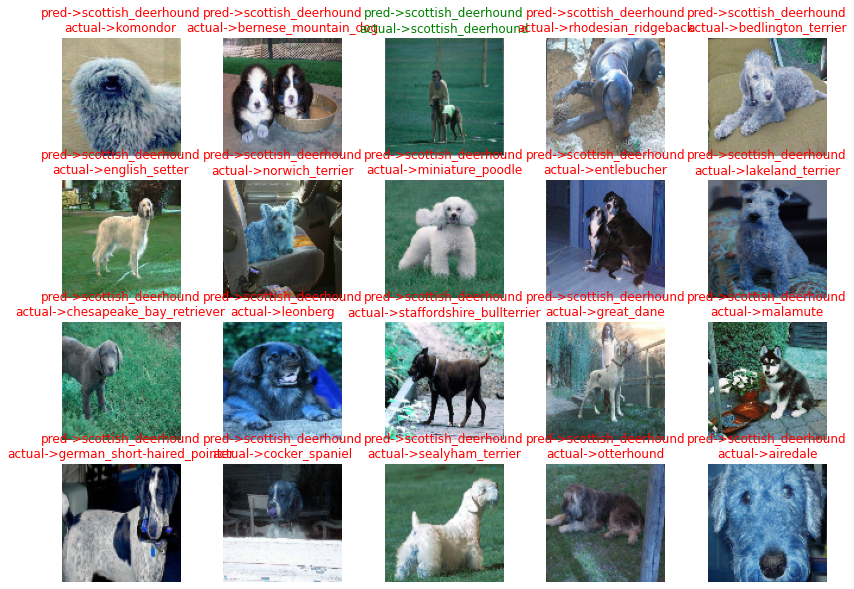

In [71]:
plotter(model_bl,val_loader)

In [103]:
model = ImagenetTransferLearning()
trainer = pl.Trainer(
    gpus = 1,
    max_epochs = 10
)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type               | Params
---------------------------------------------------------
0 | accuracy          | MulticlassAccuracy | 0     
1 | feature_extractor | Sequential         | 23.5 M
2 | classifier        | Linear             | 4.1 K 
---------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.